# Lending Club Case Study 

## Project Brief
 Here ,consumer finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile.
 Two types of risks are associated with the bank’s decision:
 
1. If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company.
2. If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.


In [255]:
# Importing the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Understanding

Step 1: Reading the file : loan.csv has 39717 rows and 111 columns . 

Summary : 
1. On the first look we can see multiple categorical and numerical columns
2. 54 columns with all values null / NAN
3. Both Categorical ( type = object ) & Numerical columns are present ( type = float64 , int64 )

In [256]:
loan_data_Df = pd.read_csv('loan.csv', low_memory = False)

print(loan_data_Df.shape)

loan_data_Df.info(verbose = True, null_counts = True)

print("We have " + str((loan_data_Df.isna().sum() == 39717).sum()) + " columns where all rows all null and these can be dropped \n" )

(39717, 111)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
id                                39717 non-null int64
member_id                         39717 non-null int64
loan_amnt                         39717 non-null int64
funded_amnt                       39717 non-null int64
funded_amnt_inv                   39717 non-null float64
term                              39717 non-null object
int_rate                          39717 non-null object
installment                       39717 non-null float64
grade                             39717 non-null object
sub_grade                         39717 non-null object
emp_title                         37258 non-null object
emp_length                        38642 non-null object
home_ownership                    39717 non-null object
annual_inc                        39717 non-null float64
verification_status               39717 non-null object
issue_d                           3971

## 2. Data Cleaning & Manipulation

Summary :
1. Drop All columns which are NAN
2. Drop the columns where > = 60% of data is NAN / null
3. Drop all the columns which contain constant value - Not signifiant ; such column cannot be used to arrive at the solution for the  Problem statement
4. Remove insignificant columns : zipcode (last digits are xx) , id , member_id , url have no business level significance 
5. Drop desc as its having too much textual information and is not useful
5. subgrade column is removed to avoid multi-collinearity - subgrade is already represented by grade column

In [257]:
# 1. Drop columns with 100% missing values
loan_data_Df.dropna(axis=1, how="all", inplace = True)

In [258]:
# 2. Drop the columns where >= 60% of data is NAN / null ( next_pymnt_d , mths_since_last_record , mths_since_last_delinq)
(round(100*(loan_data_Df.isnull().sum() / len(loan_data_Df.index)),2).sort_values(ascending = False))
loan_data_Df = loan_data_Df.loc[:, loan_data_Df.isnull().mean() < 0.6]


In [259]:
# 3. Dropping columns which are having constant value all through - This means there is no variation in data 
loan_data_Df = loan_data_Df.loc[:, loan_data_Df.apply(pd.Series.nunique) != 1] 

In [260]:
# 4. Drop the columns not relevant for analysis 
loan_data_Df = loan_data_Df.drop(labels = ['id','member_id','url','zip_code', 'sub_grade', 'desc'] , axis=1)

                 loan_amnt  funded_amnt  funded_amnt_inv
loan_amnt         1.000000     0.981578         0.940034
funded_amnt       0.981578     1.000000         0.958422
funded_amnt_inv   0.940034     0.958422         1.000000


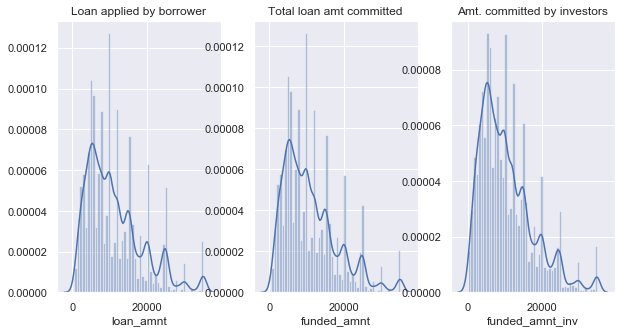

In [261]:
#Find the correlation between the three columns :loan_amnt , funded_amnt and funded_amnt_inv
loan_df_firstS = loan_data_Df.loc[:, ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']]
correl = loan_df_firstS.corr()
print(correl)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.title("Loan applied by borrower")
sns.distplot(loan_data_Df['loan_amnt'])

plt.subplot(1,3,2)
plt.title("Total loan amt committed")
sns.distplot(loan_data_Df['funded_amnt'])

plt.subplot(1,3,3)
plt.title("Amt. committed by investors")
sns.distplot(loan_data_Df['funded_amnt_inv'])

plt.show()

<font color='green'>
    
###  Inference # 1 :
##### Difference between loan_amt, funded_amnt & funded_amnt_inv is insignificant
1. All the 3 columns seem to be very highly positively corelated, hence we shall ignore the cols -  loan_amnt & funded_amt_inv
2. Most of the loan amounts are offered between 5000 to 10000
</font> 

In [262]:
#5. Drop 'loan_amnt' , 'funded_amnt_inv'. Dropped to avoid multi-collinearity
loan_data_Df = loan_data_Df.drop(labels = ['loan_amnt','funded_amnt_inv'] , axis=1)
print("The shape of loan dataframe after Cleaning ",str(loan_data_Df.shape))

The shape of loan dataframe after Cleaning  (39717, 37)


### Manipulation summary :  
    1. Split the term column to remove ' months'
    2. remove % from int_rate and revol_util
    3. Get year from issue_d column
    4. Filtering the NA values of Emp length with '0' and renaming to 'Independent'
    5. Outlier Treament - Data which is > 99% ( +/- 3 sigma ) is removed from annual_inc

### Derived metrics summary : 
   The below metrics are derived during the course of Data Analysis below 
    1. Data Driven :
       a) int_rate 
       b) revol_util 
       c) term_mth ( the 'term' data is converted to numerical for numerical analysis ) 
       d) probability of charged off ( Total number of charged off / Total loan applicants )
    2. Type Driven :
       a) issue_year , issue_month ( the column 'issue_d' is split to derive the month and year )
    2. Business Driven :
       a) installment_ratio : derived as 'installment' / 'annual_inc'

In [263]:
loan_data_Df["term_mth"] = (loan_data_Df['term'].str.replace(' months' , '')).astype(int)

loan_data_Df['int_rate'] = (loan_data_Df['int_rate'].str.split("%", n=1, expand = True))
loan_data_Df['revol_util'] = (loan_data_Df['revol_util'].str.split("%", n=1, expand = True))

#Convert other columns to numeric 
numeric_columns = ['funded_amnt','installment','annual_inc','dti', 'int_rate', 'revol_util']
loan_data_Df[numeric_columns] = loan_data_Df[numeric_columns].apply(pd.to_numeric)

#Filtering the NA values of Emp length with '0' and renaming to 'Independent'
loan_data_Df['emp_length'].unique()
loan_data_Df['emp_length'].fillna('0',inplace=True)
loan_data_Df['emp_length'].replace(['n/a'],'Independent',inplace=True)

In [264]:
#get the number of numerical features 
numerical_feats=loan_data_Df.dtypes[loan_data_Df.dtypes != 'object'].index
print('# of Numerical features' , len(numerical_feats))
print('# of Numerical features are : ' , numerical_feats)


#get the number of categorical features 
categorical_feats=loan_data_Df.dtypes[loan_data_Df.dtypes == 'object'].index
print('# of Categorical features' , len(categorical_feats))
print('# of Categorical features are : ' , categorical_feats)

# of Numerical features 24
# of Numerical features are :  Index(['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies', 'term_mth'],
      dtype='object')
# of Categorical features 14
# of Categorical features are :  Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')


In [265]:
# Type Driven Metrics : issue_year and issue_month from issue_d
loan_data_Df['issue_d'] = pd.to_datetime(loan_data_Df['issue_d'],format = '%b-%y')
loan_data_Df['issue_year'],loan_data_Df['issue_month'] = loan_data_Df.issue_d.dt.year, loan_data_Df.issue_d.dt.month

In [266]:
#Create bins to analyze data 

print("finding the min, max and std of funded amount - Min: " + str(loan_data_Df['funded_amnt'].min()) + " ; Max : " 
      +  str(loan_data_Df['funded_amnt'].max()) + " ; Std :  " + str(loan_data_Df['funded_amnt'].std()))

#Based on output, creating bins to sort the values
bins = [0,10000,20000,30000,40000]
slot = ['0-10000','10000-20000','20000-30000','30000 and above']
loan_data_Df.loc[: ,'funded_amnt_range'] = pd.cut(loan_data_Df['funded_amnt'], bins, labels = slot)


print("finding the min, max and std of annual Income amount - Min: " + str(loan_data_Df['annual_inc'].min()) + " ; Max : " 
      +  str(loan_data_Df['annual_inc'].max()) + " ; Std :  " + str(loan_data_Df['annual_inc'].std()))

#Based on output, creating bins to sort the values
bins = [0,25000,50000,75000,100000,1000000]
slot = ['0-25000','25000-50000','50000-75000','75000-100000','100000 and above']
loan_data_Df.loc[: ,'annual_inc_range'] = pd.cut(loan_data_Df['annual_inc'],bins, labels = slot)



finding the min, max and std of funded amount - Min: 500 ; Max : 35000 ; Std :  7187.238669927401
finding the min, max and std of annual Income amount - Min: 4000.0 ; Max : 6000000.0 ; Std :  63793.765790045836


## 3. Data Analysis 

In [267]:
loan_data_Df.shape

(39717, 42)

In [268]:
numerical_feats_DF = loan_data_Df.loc[: , numerical_feats]

corrnum = numerical_feats_DF.corr() 
corrnum.style.background_gradient(cmap='coolwarm').set_precision(2)

,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,term_mth
funded_amnt,1,0.31,0.96,0.27,0.066,-0.032,0.0093,0.18,-0.052,0.31,0.07,0.25,0.19,0.19,0.9,0.87,0.87,0.74,0.047,0.14,0.075,0.45,-0.039,0.34
int_rate,0.31,1,0.28,0.053,0.11,0.16,0.13,0.01,0.097,0.097,0.47,-0.044,0.13,0.13,0.31,0.3,0.19,0.53,0.093,0.12,0.066,0.16,0.083,0.45
installment,0.96,0.28,1,0.27,0.054,-0.02,0.0097,0.17,-0.047,0.31,0.095,0.23,0.13,0.12,0.86,0.82,0.85,0.63,0.057,0.12,0.075,0.4,-0.034,0.1
annual_inc,0.27,0.053,0.27,1,-0.12,0.023,0.034,0.16,-0.019,0.28,0.018,0.24,0.034,0.033,0.26,0.25,0.26,0.19,0.0062,0.022,0.016,0.14,-0.017,0.047
dti,0.066,0.11,0.054,-0.12,1,-0.034,0.0014,0.29,-0.0046,0.23,0.28,0.23,0.036,0.036,0.065,0.072,0.041,0.11,-0.012,0.025,0.011,0.0052,0.0057,0.082
delinq_2yrs,-0.032,0.16,-0.02,0.023,-0.034,1,0.0081,0.012,0.0075,-0.055,-0.043,0.068,-0.003,-0.0032,-0.023,-0.029,-0.039,0.023,0.031,0.012,0.014,-0.012,0.0034,0.0064
inq_last_6mths,0.0093,0.13,0.0097,0.034,0.0014,0.0081,1,0.092,0.025,-0.022,-0.069,0.11,-0.012,-0.012,-0.011,-0.02,-0.023,0.022,0.031,0.019,0.012,0.029,0.016,0.041
open_acc,0.18,0.01,0.17,0.16,0.29,0.012,0.092,1,0.00017,0.29,-0.09,0.69,0.029,0.029,0.16,0.15,0.16,0.12,-0.019,0.016,0.0062,0.079,0.0059,0.051
pub_rec,-0.052,0.097,-0.047,-0.019,-0.0046,0.0075,0.025,0.00017,1,-0.061,0.059,-0.024,-0.013,-0.013,-0.054,-0.054,-0.065,-0.0075,-0.0021,-0.0055,-0.0055,-0.032,0.85,0.0072
revol_bal,0.31,0.097,0.31,0.28,0.23,-0.055,-0.022,0.29,-0.061,1,0.3,0.31,0.06,0.06,0.29,0.28,0.28,0.24,0.0038,0.042,0.022,0.12,-0.049,0.072


<font color ='orange'>

### Perform cleaning to avoid multicollinearity - Drop the columns with >0.8 collinearity

</font>

In [269]:
corrnum1 = corrnum[(corrnum>0.8) & (corrnum<1)]
corrnum1.dropna(axis=1,how='all',inplace = True)
corrnum1.dropna(axis=0,how='all',inplace = True)
corrnum1

def correl(X_train):
    cor = X_train.corr()
    corrm = np.corrcoef(X_train.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]
    ## change this value to get more correlation results        
    thresh = 0.8
    display(high_cor[high_cor>thresh])
correl(numerical_feats_DF)
loan_data_Df.drop(labels = ['out_prncp_inv', 'total_rec_prncp', 'total_pymnt_inv','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'pub_rec_bankruptcies', 'total_rec_int'] , axis=1, inplace = True)
# Note that installment is not dropped as its used to derive Installment_ratio

out_prncp        out_prncp_inv          0.999827
total_rec_prncp  total_pymnt            0.971472
total_pymnt_inv  total_pymnt            0.970815
installment      funded_amnt            0.956159
total_rec_prncp  total_pymnt_inv        0.939581
funded_amnt      total_pymnt            0.903160
                 total_pymnt_inv        0.870799
                 total_rec_prncp        0.870255
installment      total_pymnt            0.856928
total_rec_prncp  installment            0.850773
pub_rec          pub_rec_bankruptcies   0.847305
total_rec_int    total_pymnt            0.828758
installment      total_pymnt_inv        0.817416
total_rec_int    total_pymnt_inv        0.815615
dtype: float64

In [270]:
# check the columns in data frame
loan_data_Df.shape

(39717, 36)

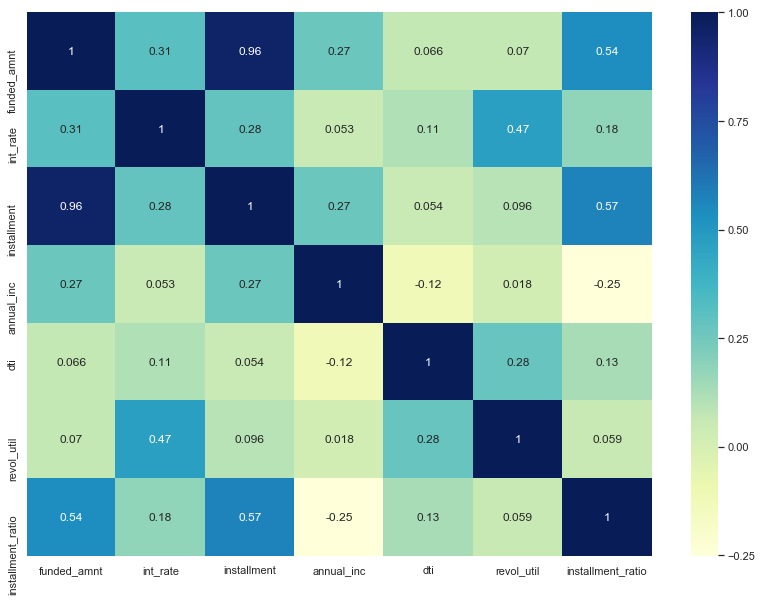

In [287]:
# Heat map created on subset of numerical data along with Derived Metric (installment_ratio) 

loan_data_Df["installment_ratio"] = (loan_data_Df.installment / loan_data_Df.annual_inc)

loan_numeric = loan_data_Df[["funded_amnt", "int_rate", "installment", "annual_inc", "dti", "revol_util", 
                     "installment_ratio"]]

loan_numeric.head()
cor = loan_numeric.corr()
plt.figure(figsize=(14,10))

sns.heatmap(cor, cmap="YlGnBu", annot = True)
plt.show()

<font color='green'>    

###  Inference # 2:
    
1. Installment and funded_amount are highly correlated
2. pub_rec_bankruptcies and pub_rec are highlighy correlated
</font> 

### User Defined Function for performing analysis on Loan data

In [288]:
def createCrosstab (df,col):
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),2)
    # Add the Probability as the last column in the cross tab
    crosstab = crosstab[0:-1]
    crosstab = crosstab.sort_values('Probability_Charged Off',ascending=False)
    return crosstab

In [289]:
def bivariateProb (df,col,stacked= True):
    
    # get dataframe from crosstab function
    crossDFrame = createCrosstab(df,col)
    linePlot = crossDFrame[['Probability_Charged Off']]      
    barPlot =  crossDFrame.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'r')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax2.grid(False) ## for not getting grids
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(), color = 'b', fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) ## for x-ticks 45'
    
    plt.show()

## 3.1 Univariate Analysis 

### Univariate Analysis 1. Loan status


percentage of Charged off Loans is  14.16


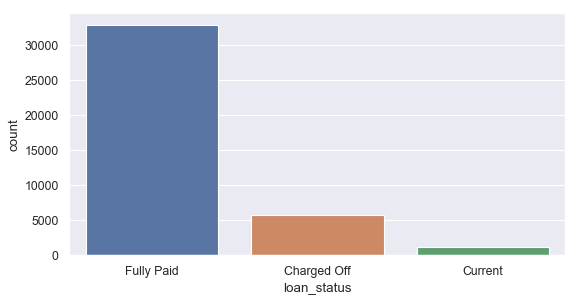

In [290]:
# Univariate Analysis : Loan status
#****************************************
loan_data_Df['loan_status_num'] = np.where((loan_data_Df['loan_status'] == 'Charged Off') , 0 , 1)
plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="loan_status", data=loan_data_Df, order = loan_data_Df['loan_status'].value_counts().index)


# Get the percentage of Charged off Loans
perc = round(100*(len(loan_data_Df.loc[(loan_data_Df['loan_status'] == 'Charged Off')])/len(loan_data_Df['loan_status'])),2)

print("percentage of Charged off Loans is ",str(perc))

 <font color='green'>

### Inference #3:
1. % of Charged Off customers is 14% 
2. Range of customers Charged off is upto 5000

</font>    

### Univariate Analysis #2 : Purpose of The loan 


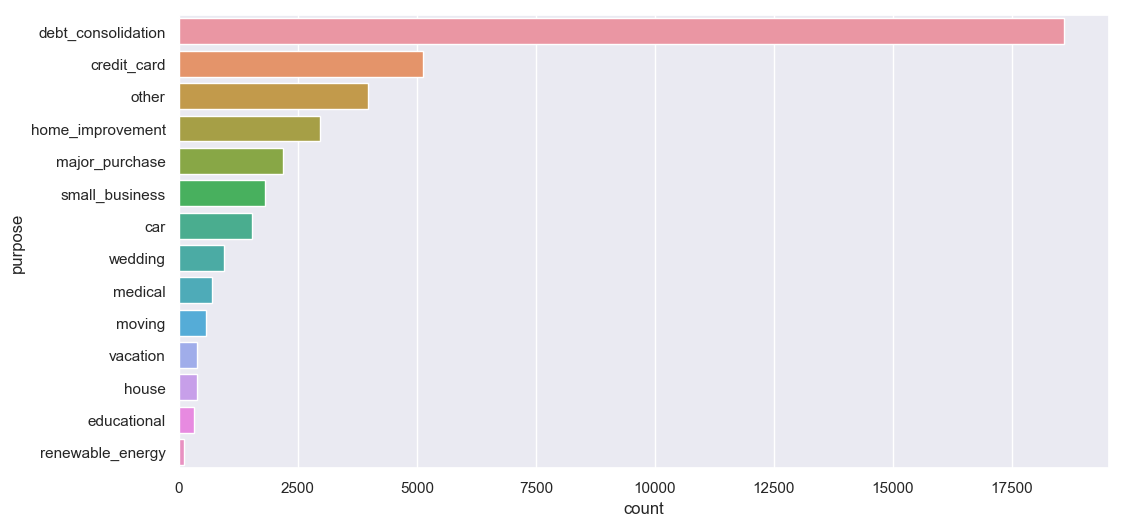

In [291]:

sns.set(style="darkgrid")

plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')

sns.countplot(data=loan_data_Df, y='purpose', order=loan_data_Df['purpose'].value_counts().index ) 

<font color = 'green'>

### Inference #4:
1. The most dominant purpose of loan is 'debt_consolidation' - thus the loan is mostly taken to pay off other debts / liabilities.
2. A close second is 'credit card'
2. The least number of loans are taken for 'renewable_energy'

</font>               

### Segemented Univariate Analysis #3 :  Issue Year

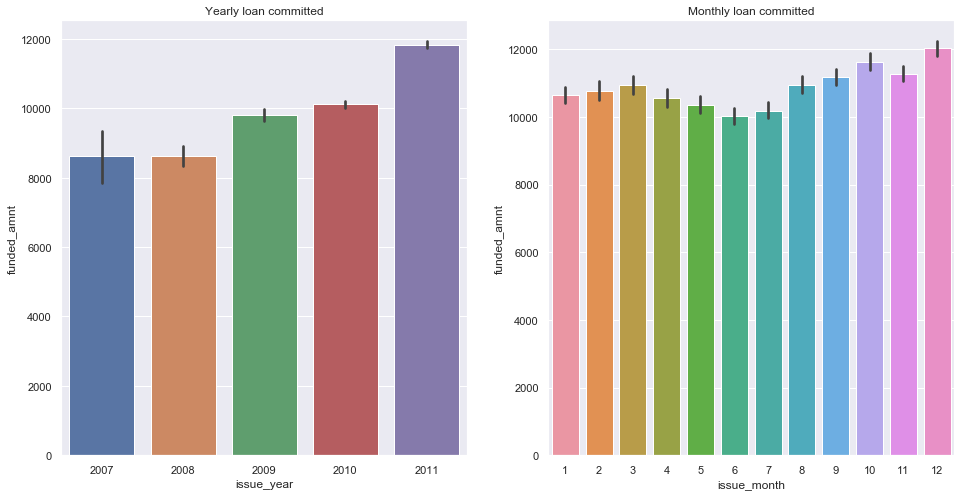

In [292]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.barplot(x = "issue_year", y = "funded_amnt", data= loan_data_Df)
plt.title("Yearly loan committed")

plt.subplot(1,2,2)
sns.barplot(x = "issue_month", y = "funded_amnt", data=loan_data_Df)
plt.title("Monthly loan committed")

plt.show()

<font color = 'green'>

### Inference #5:
1. Funded amount has been steadily increasing from 2007 to 2011 . 2011 has the highest funding amount
2. Loan issuance is least in the Month of June 
3. The Loan issuance steadily comes down after first quarter & starts rising from July

</font> 

### Univariate Analysis #4 :  Term

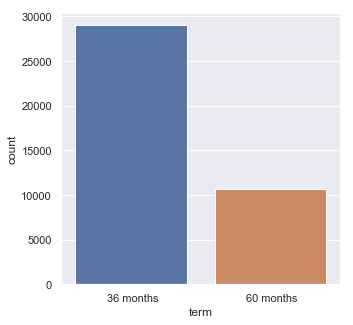

percentage of Loans for 36 months  73.19
percentage of Loans for 60 months  26.81


In [293]:
plt.figure(figsize=(5, 5))
sns.countplot(loan_data_Df['term'])
plt.show()

# Get the percentage of loans for 36 month term
perc = round(100*(len(loan_data_Df.loc[(loan_data_Df['term_mth'] == 36)])/len(loan_data_Df)),2)
print("percentage of Loans for 36 months ",str(perc))

# Get the percentage of loans for 60 month term
perc = round(100*(len(loan_data_Df.loc[(loan_data_Df['term_mth'] == 60)])/len(loan_data_Df)),2)
print("percentage of Loans for 60 months ",str(perc))


<font color = 'green'>

### Inference #6:
1. 73% applicants have chosen 36 months as a loan tenure and 27 % applicants have chosen 60 months as tenure


</font>

### Univariate Analysis #5 :  Home Ownership wise Loan

percentage of Loans for home ownership purpose :  home_ownership
MORTGAGE   44.575424
OWN         7.719103
RENT       47.705473
Name: purpose, dtype: float64


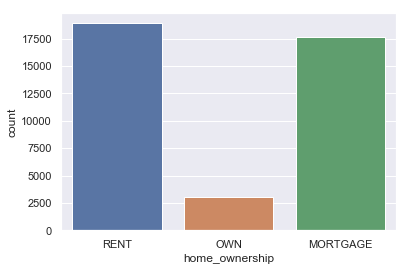

In [294]:
loan_data_Df['home_ownership'].unique()
ho=['OTHER','NONE']
loan_data_Df.drop(loan_data_Df[loan_data_Df['home_ownership'].isin(ho)].index,inplace=True)
loan_data_Df.home_ownership.unique()
(((loan_data_Df.groupby('home_ownership').purpose.count())/len(loan_data_Df))*100).sort_values(ascending=False)
sns.countplot(loan_data_Df['home_ownership'])

print("percentage of Loans for home ownership purpose : ", str(((loan_data_Df.groupby('home_ownership').purpose.count())/len(loan_data_Df))*100))

<font color=green>

### Inference #7:
1. Insights: Maximum no. of loans are taken by the people who are staying at Rent: 48%  or Mortgage houses:45%


</font>

# 3.2  Bivariate Analysis 

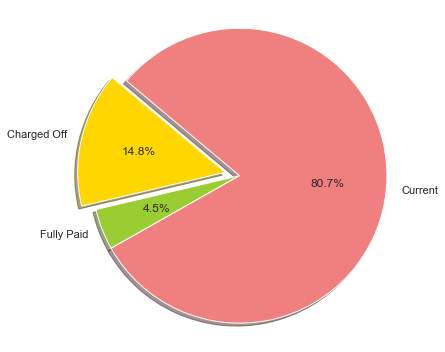

In [295]:
## Ascertain the % contribution of different loan status
(loan_data_Df.groupby("loan_status").funded_amnt.sum() / sum(loan_data_Df["funded_amnt"]))*100

## Pie chart to showcase the contribution share
plt.figure(figsize=(6,6))

labels = 'Charged Off', 'Fully Paid', 'Current'
sizes = [14.8, 4.5, 80.7]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

<font color = 'green'>
    
### Inference #8
1. 14.78 % is the total contribution of Charged Off Loans over the Funded amount

</font>

#### User Defined Function for drawing plot on bivariate analysis 

In [296]:
def bivariate_Analysis(variable) :
    plt.figure(figsize=(12,6))
    sns.countplot(variable, hue="loan_status", data=loan_data_Df)

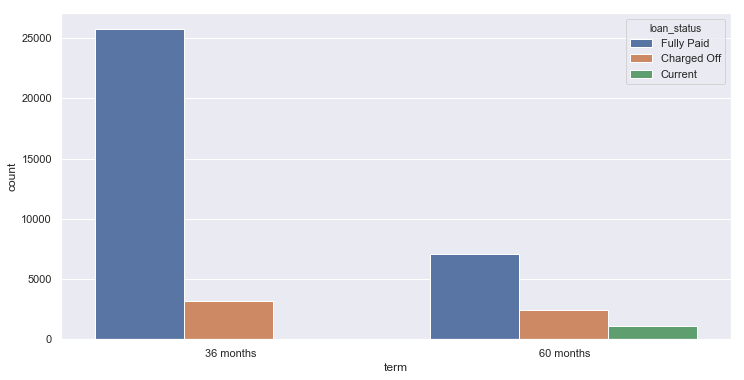

In [297]:
bivariate_Analysis('term')

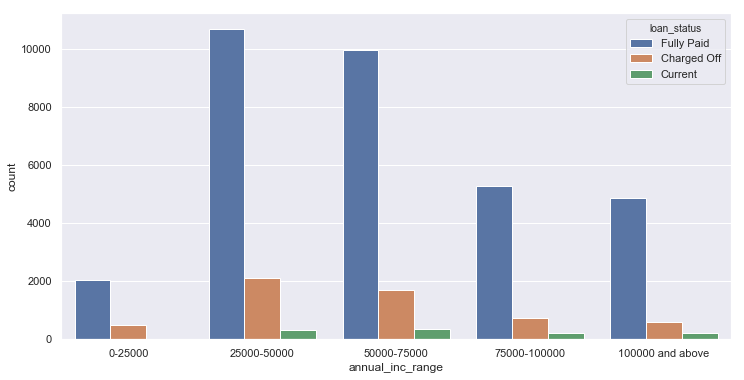

In [298]:
bivariate_Analysis('annual_inc_range')

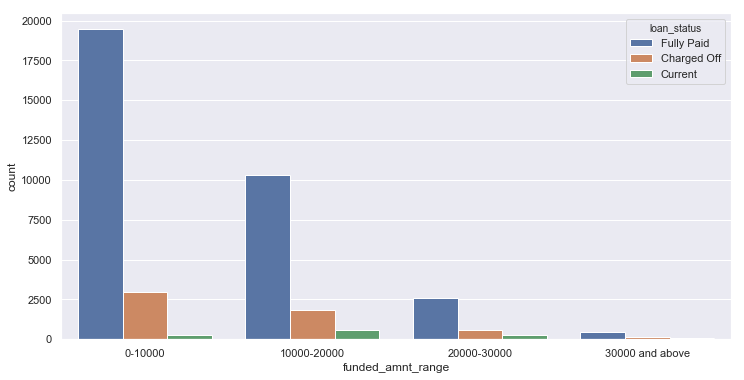

In [299]:
bivariate_Analysis('funded_amnt_range')

Text(0.5, 1.0, 'Loan_status vs installment_ratio')

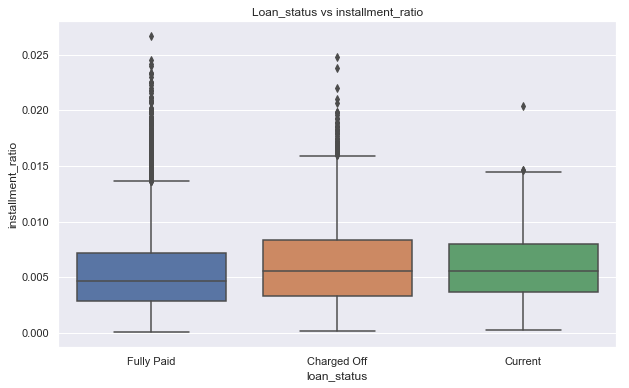

In [300]:
plt.figure(figsize=(10, 6))

sns.boxplot(x = "loan_status", y= "installment_ratio", data = loan_data_Df)
plt.title("Loan_status vs installment_ratio")


<font color=green>

### Inference #9:
1. Insights: With regards to the installment ratio (annual income vs installment), the inference seems to be insignificant
2. The median value of the "Fully Paid", "Charged Off" & "Current" is approx at 0.005


</font>

### Bivariate Analysis :  annual_income vs installment

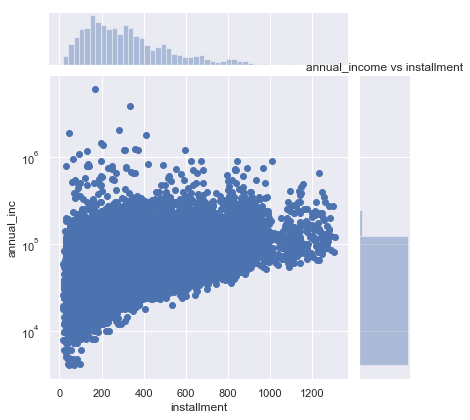

In [301]:
sns.jointplot(x = "installment", y = "annual_inc", data= loan_data_Df, kind = "scatter")
plt.title("annual_income vs installment")
plt.yscale("log")

plt.show()

<font color=green>

### Inference #10:
1. Insights: The scatter plot between annual income & installment seems to be moderately positively corelated
2. Most of the Loan takers are having annual income < 100000 and the Installment is < 600

</font>

### Bivariate Analysis :  annual_income vs dti

<Figure size 1152x576 with 0 Axes>

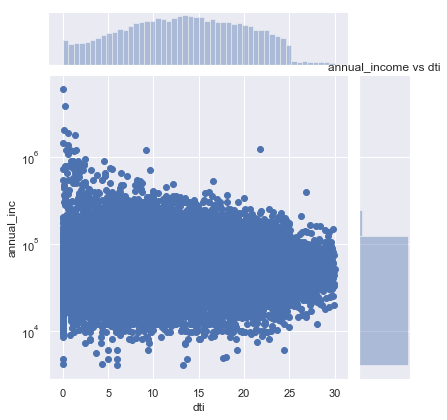

In [302]:
plt.figure(figsize=(16, 8))

sns.jointplot(x = "dti", y = "annual_inc", data= loan_data_Df, kind = "scatter")
plt.title("annual_income vs dti")
plt.yscale("log")


<font color=green>

### Inference #11:
1. Insights: The scatter plot between annual income & dti seems to be low negatively corelated. Most of the dti is
    concentrated between the annual income of 10,000 to 100,000
2. The plot also identifies few outliers in annual income


</font>

### Bivariate Analysis :  Purpose vs amount of loan granted

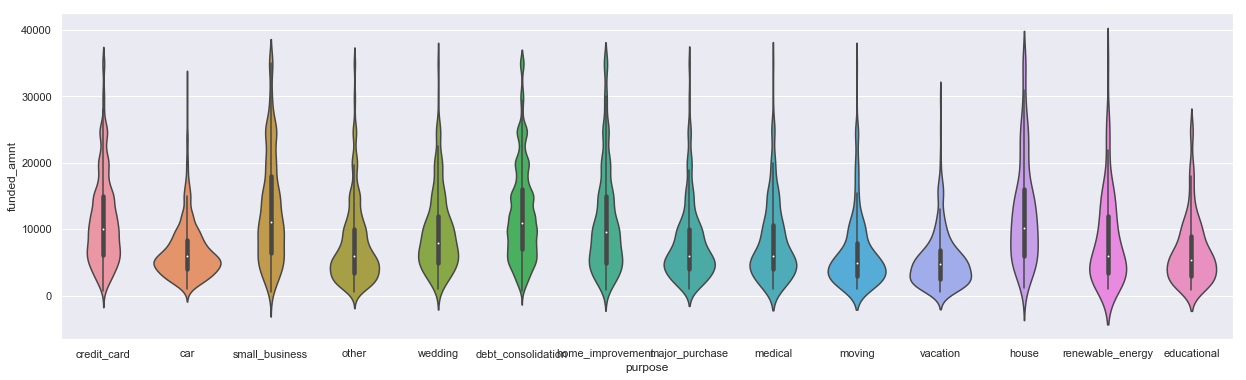

In [303]:
## Purpose vs amount of loan granted

plt.figure(figsize=(21, 6))
sns.violinplot(x = loan_data_Df.purpose, y = loan_data_Df.funded_amnt)


<font color=green>

### Inference #12:
1. Insights: The Violinplot between the funded amount & the purpose proves that the highest median value is for
    debt consolidation, followed by small business, credit card, home improvement, home etc.
2. Insights: The median value for the top drivers seem to be approx at 10000


</font>

### Bivariate Analyis : State vs Amount of Loan funded

Text(0.5, 1.0, 'State wise funded amt')

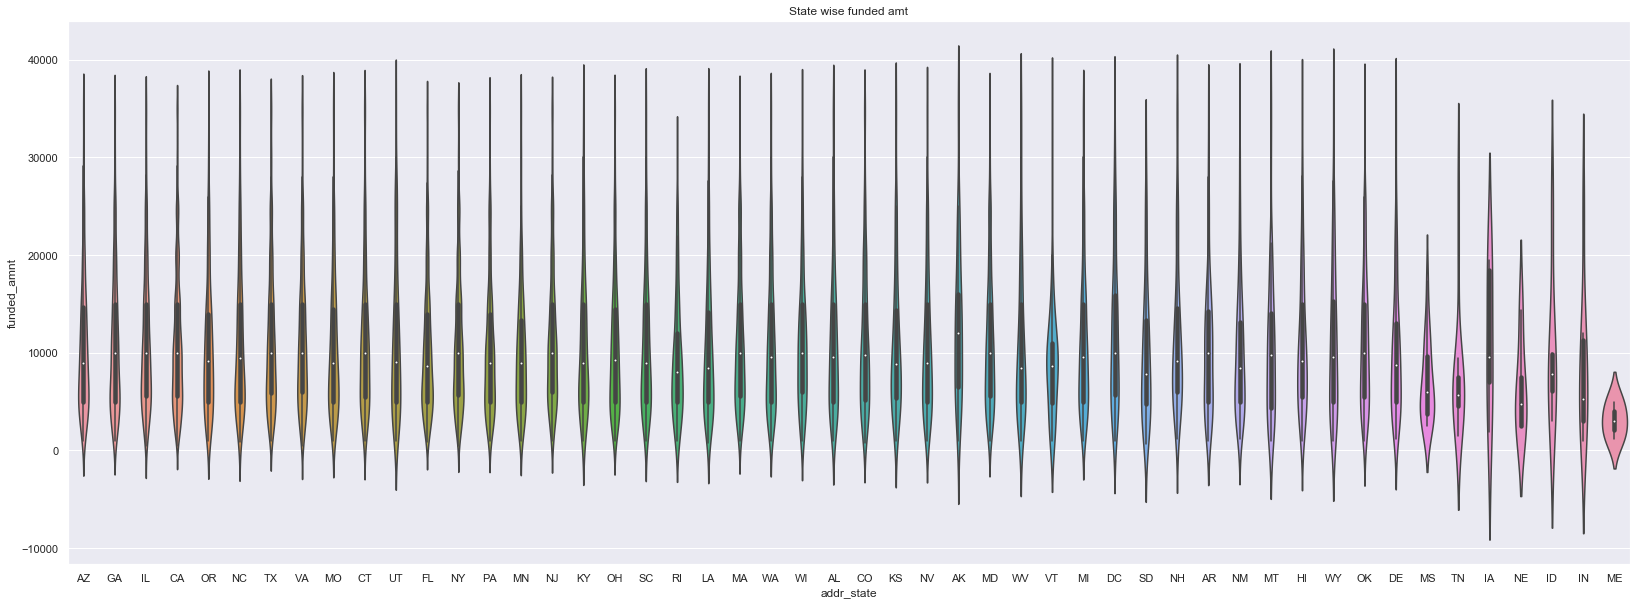

In [304]:
## State vs amount of loan granted

plt.figure(figsize=(28, 10))
sns.violinplot(x = loan_data_Df.addr_state, y = loan_data_Df.funded_amnt)
plt.title("State wise funded amt")

<font color=green>

### Inference #13:
1. Insights: The Violinplot between the state vs the funded amount. Most of the states have a median funded amt @ approx. 10000

</font>

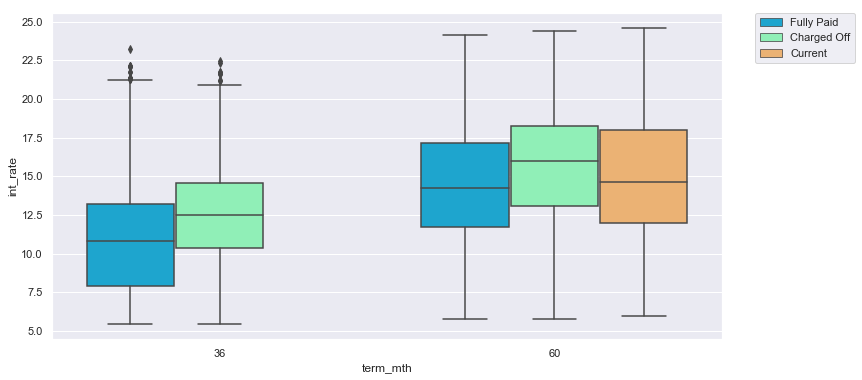

In [305]:
plt.figure(figsize=(12,6))
sns.boxplot(x = "term_mth", y = "int_rate", data = loan_data_Df, palette="rainbow" , hue="loan_status")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

<font color ='green'>

### Inference #14:
1. Insights: Interest rate is higher for 60 month in comparison for 36 month
    
</font>

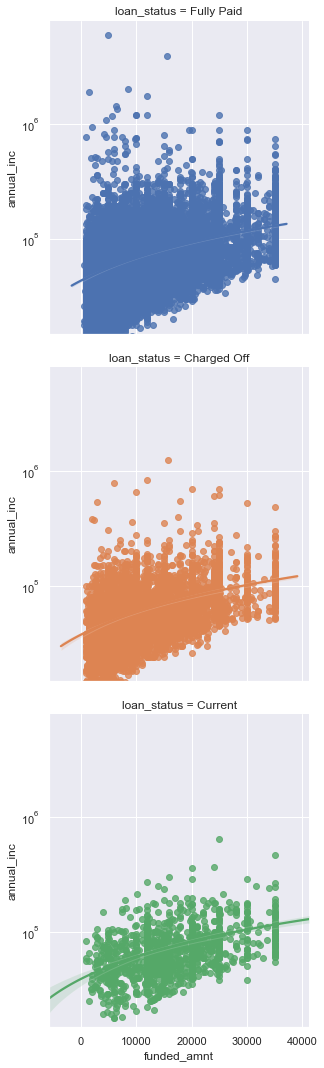

In [306]:
sns.lmplot(x = "funded_amnt", y = "annual_inc", data = loan_data_Df, row = "loan_status", hue = "loan_status")
plt.yscale("log")

<font color=green>

### Inference #15:
1. Insights: The funded amount vs. annual inc is highly positively corelated

</font>

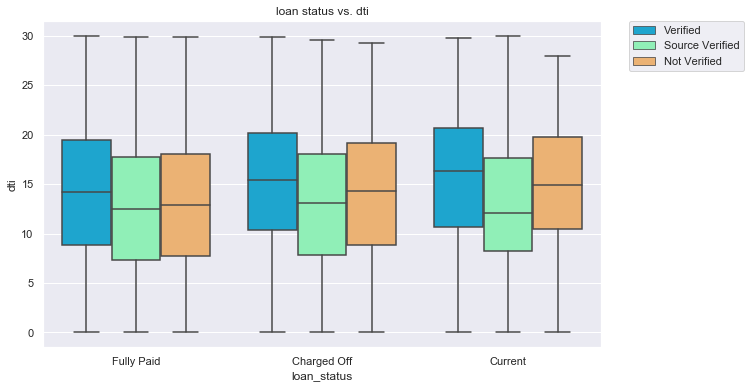

In [307]:
plt.figure(figsize=(10,6))

sns.boxplot(x = "loan_status", y = "dti", hue = "verification_status",data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)
plt.title("loan status vs. dti")

plt.show()

<font color=green>

### Inference #16:
1. Insights: The loan status vs. dti with regards to the verification status, is not significant enough

</font>

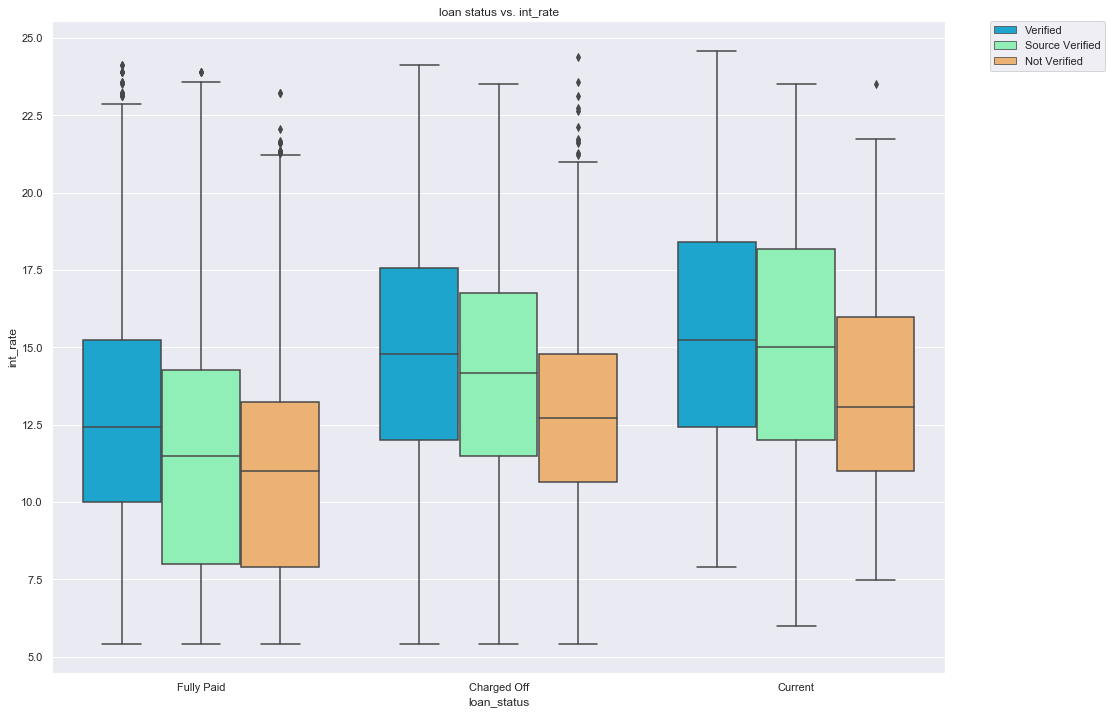

In [310]:
plt.figure(figsize=(16,12))

sns.boxplot(x = "loan_status", y = "int_rate", hue = "verification_status",data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)
plt.title("loan status vs. int_rate")

plt.show()

<font color=green>

### Inference #17:
1. Insights: The int rate for the verified source seems to be the same for different loan status
2. Insights: However, for non verified sources the rate of interest seems to be less than the other verified sources.

</font>

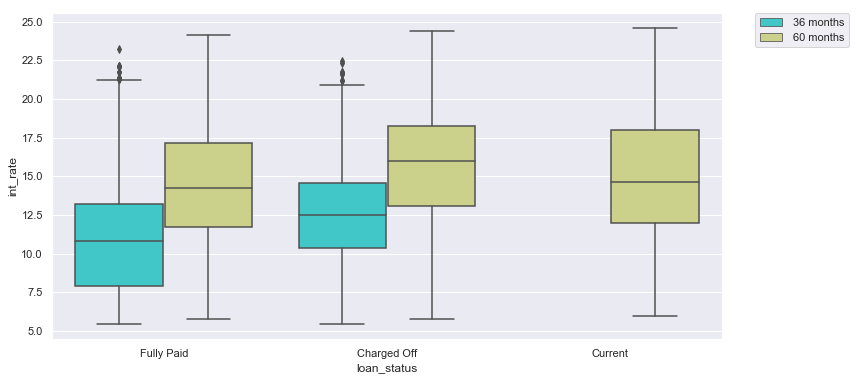

In [311]:
plt.figure(figsize=(12,6))

sns.boxplot(x = "loan_status", y = "int_rate", hue = "term",data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #18:
1. Insights: The int rate seems to be significantly higher for the 60 month in comparison to 36 month for all sections of borrower
2. Insights: The int rate seems to be significantly higher for both the 36 month & 60 month for the Charged off section of borrower

</font>

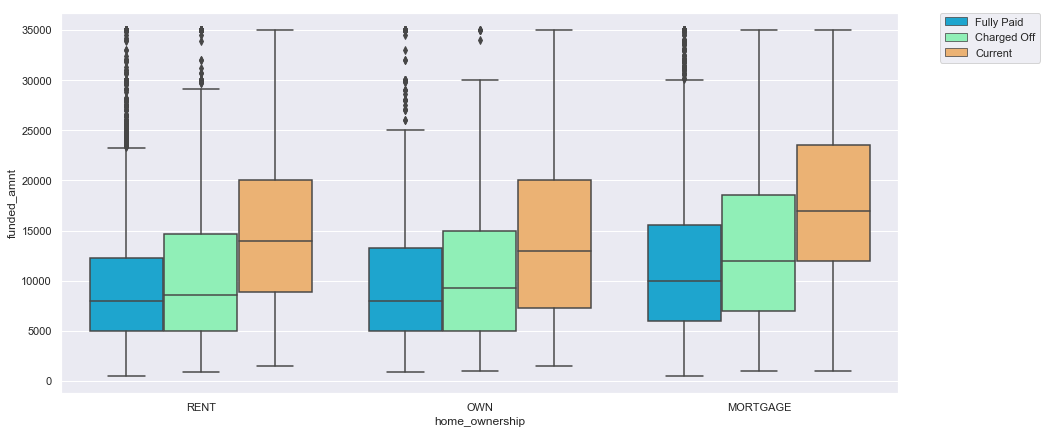

In [312]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "home_ownership", y = "funded_amnt", hue = "loan_status", data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)


<font color=green>

### Inference #19:
1. Insights: No significance can be drawn with respect to the funded amount & the home ownership

</font>

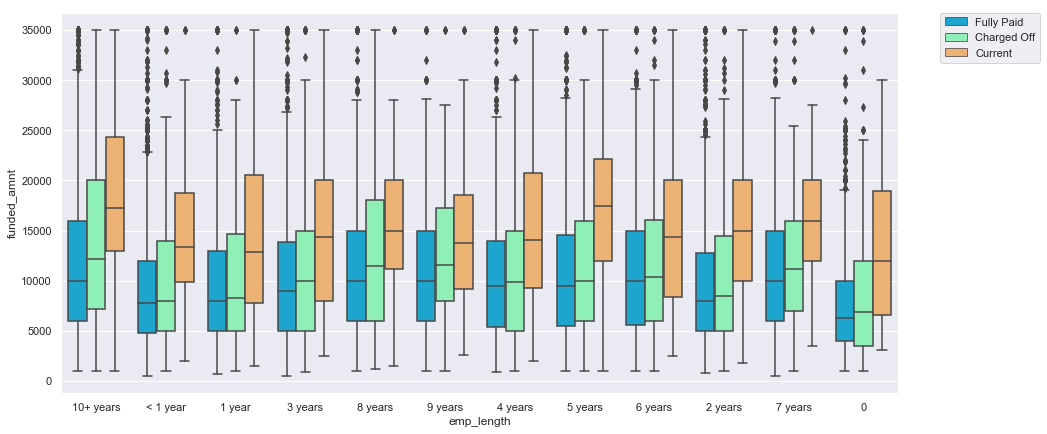

In [313]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "emp_length", y = "funded_amnt", hue = "loan_status", data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #20:
1. Insights: The range of loan taken by the borrowers are from all ranges of employment length
2. Insights: The charged off borrowers with no employment lenght (currently treated as independent) seems to have 
the funding amount <7500
3. Most of the charged off borrowers have their funded amount ranging from 7500 - 10000    

</font>

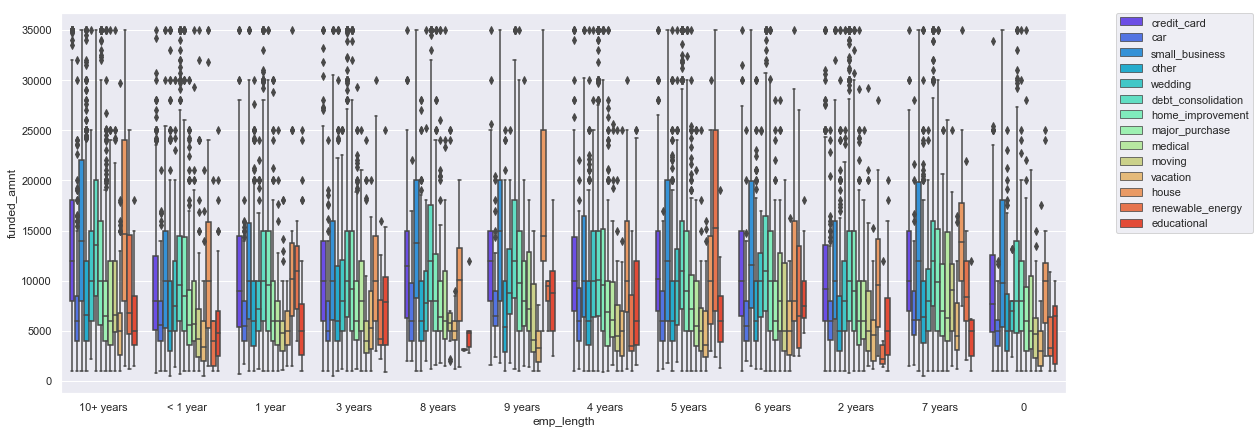

In [314]:
plt.figure(figsize=(18,7))

sns.boxplot(x = "emp_length", y = "funded_amnt", hue = "purpose", data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #21:
1. Insights: No significance can be drawn with respect to the employment length & the purpose of the loan with respect to
the overall funded amount

</font>

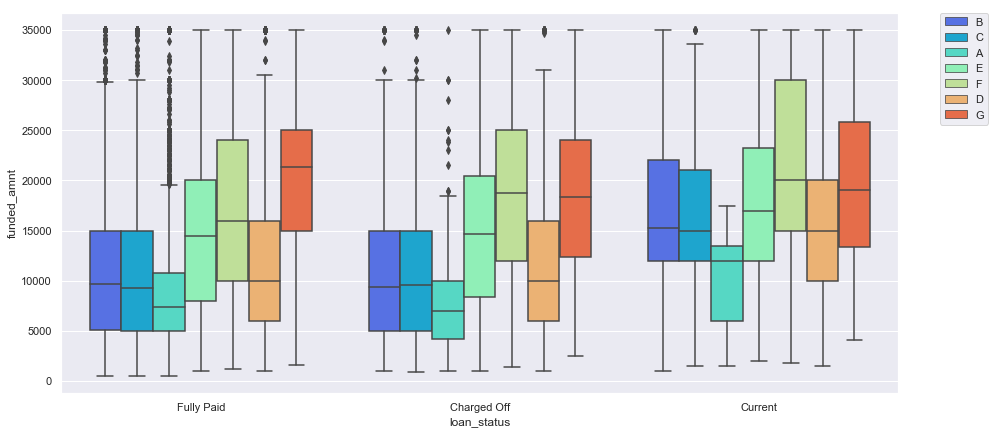

In [315]:
plt.figure(figsize=(15,7))

sns.boxplot(x = "loan_status", y = "funded_amnt", hue = "grade", data = loan_data_Df, palette="rainbow")
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #22:
1. Insights: The funded amount for the Charged Off borrowers seems to be the lowest for the borrowers in Grade A
2. Insights: The median funded for the Charged Off borrowers amount seems to be the highest for Grade F & followed by Grade G

</font>

In [316]:
loan_emp = loan_data_Df.emp_length.value_counts()/ len(loan_data_Df)*100
loan_emp = loan_emp.to_frame()
loan_emp = loan_emp.reset_index()
loan_emp.columns = ["emp_prd", "empmt_count"]
loan_emp

,emp_prd,empmt_count
0,10+ years,22.364701
1,< 1 year,11.510501
2,2 years,11.051090
3,3 years,10.311490
4,4 years,8.655594
5,5 years,8.269386
6,1 year,8.140650
7,6 years,5.616418
8,7 years,4.467892
9,8 years,3.723243


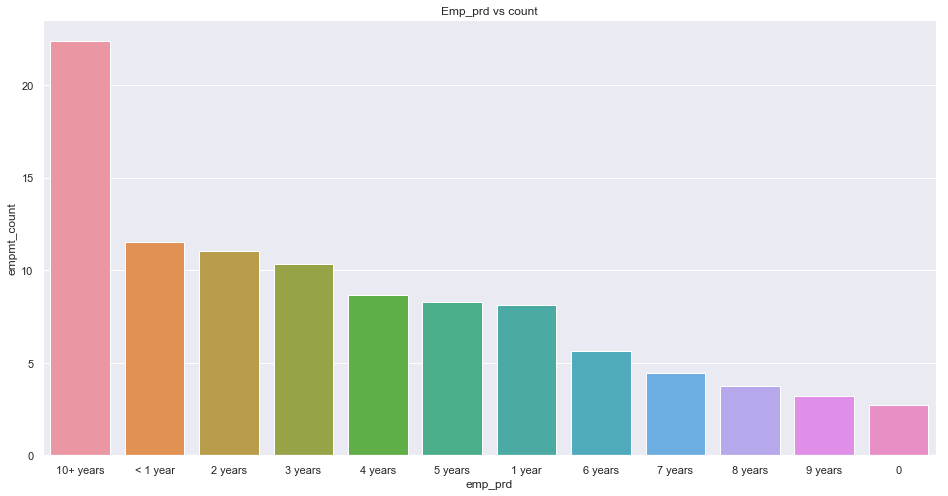

In [317]:
plt.figure(figsize=(16, 8))

sns.barplot(x = "emp_prd", y = "empmt_count", data= loan_emp)
plt.title("Emp_prd vs count")

plt.show()

<font color=green>

### Inference #23:
1. Insights: Most of the borrowers availaing loan is with the employment length of more than 10 years, followed by individual
with less than 1 year experience (or people termed as independent)
    
</font>

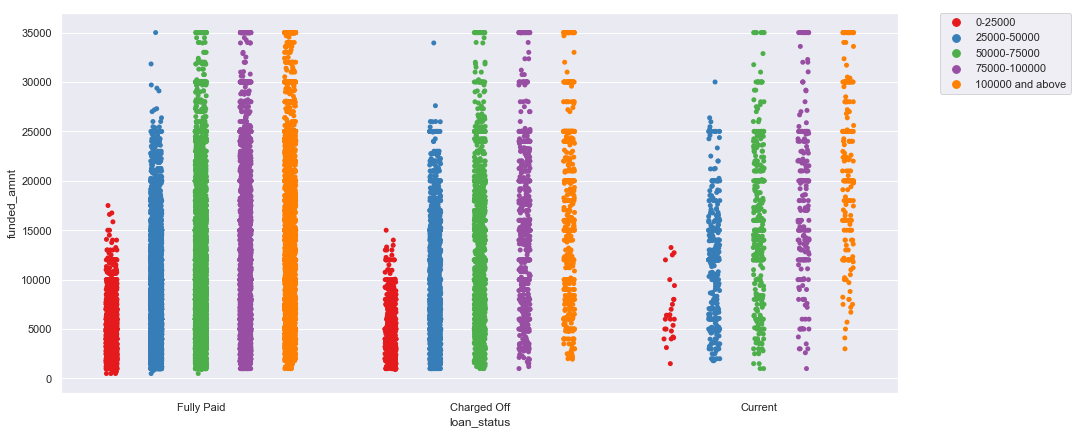

In [318]:
plt.figure(figsize=(15,7))

sns.stripplot(x = "loan_status", y = "funded_amnt", data = loan_data_Df, jitter=True, hue = "annual_inc_range", palette="Set1", dodge = True)
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #24:
1. Insights: Most of the borrowers from the charged off section is having an annual income between 50000 - 100000

</font>

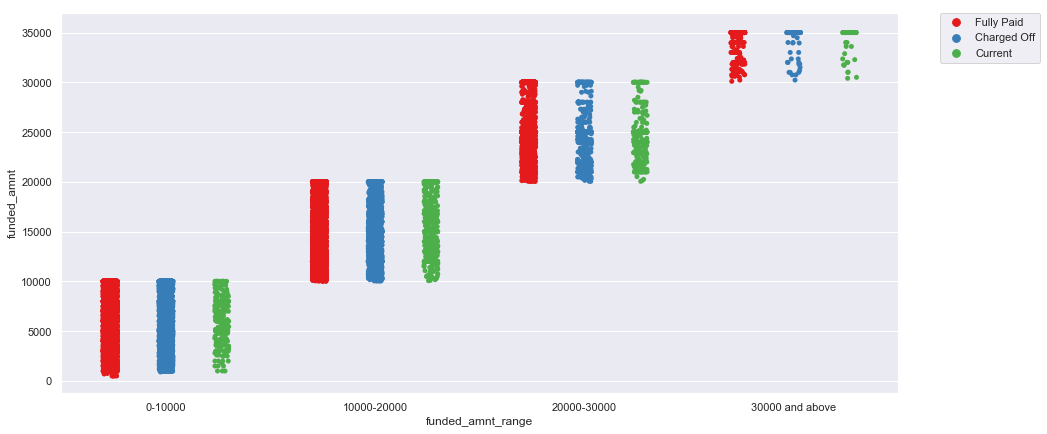

In [319]:
plt.figure(figsize=(15,7))

sns.stripplot(x = "funded_amnt_range", y = "funded_amnt", data = loan_data_Df, jitter=True, hue = "loan_status", palette="Set1", dodge = True)
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #25:
1. Insights: The funded amount less than 20000, seems to have high probability of being charged off in comaparison to others

</font>

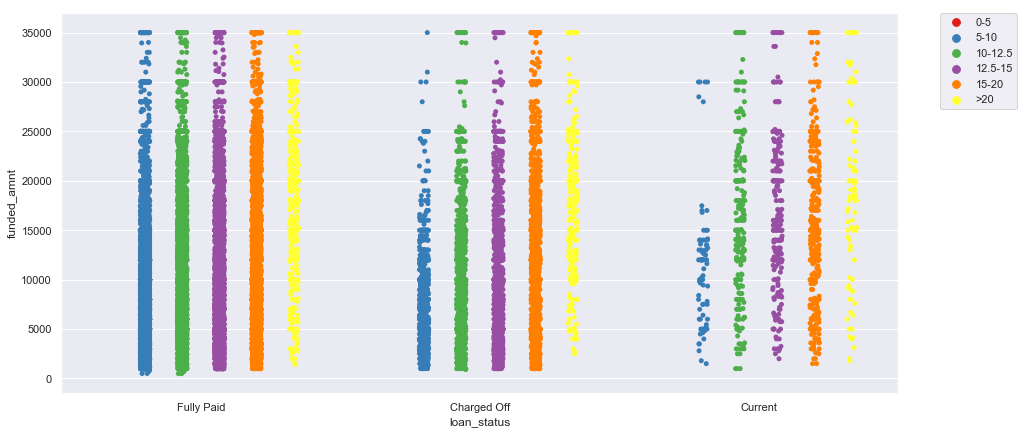

In [320]:
bins = [0, 5, 10, 12.5, 15, 20, 25]
slot = ['0-5', '5-10', '10-12.5', '12.5-15', '15-20', '>20']
loan_data_Df.loc[: , 'int_rate_bin'] = pd.cut(loan_data_Df['int_rate'], bins, labels=slot)

plt.figure(figsize=(15,7))

sns.stripplot(x = "loan_status", y = "funded_amnt", data = loan_data_Df, jitter=True, hue = "int_rate_bin", palette="Set1", dodge = True)
plt.legend(bbox_to_anchor = (1.05, 1), loc =2, borderaxespad = 0)

plt.show()

<font color=green>

### Inference #26:
1. Insights: The int rate between 12.5 to 20 may comparatively have higher chances of turning into a charged off

</font>

## Bivariate Distribution : Analysis against Probability of Loan status being Charged off

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
purpose,,,,,
small_business,471,74,1273,1818,0.260000
renewable_energy,19,1,82,102,0.190000
educational,56,0,266,322,0.170000
house,59,14,307,380,0.160000
moving,91,7,484,582,0.160000
other,631,128,3219,3978,0.160000
debt_consolidation,2760,586,15254,18600,0.150000
medical,106,12,572,690,0.150000
vacation,53,6,322,381,0.140000


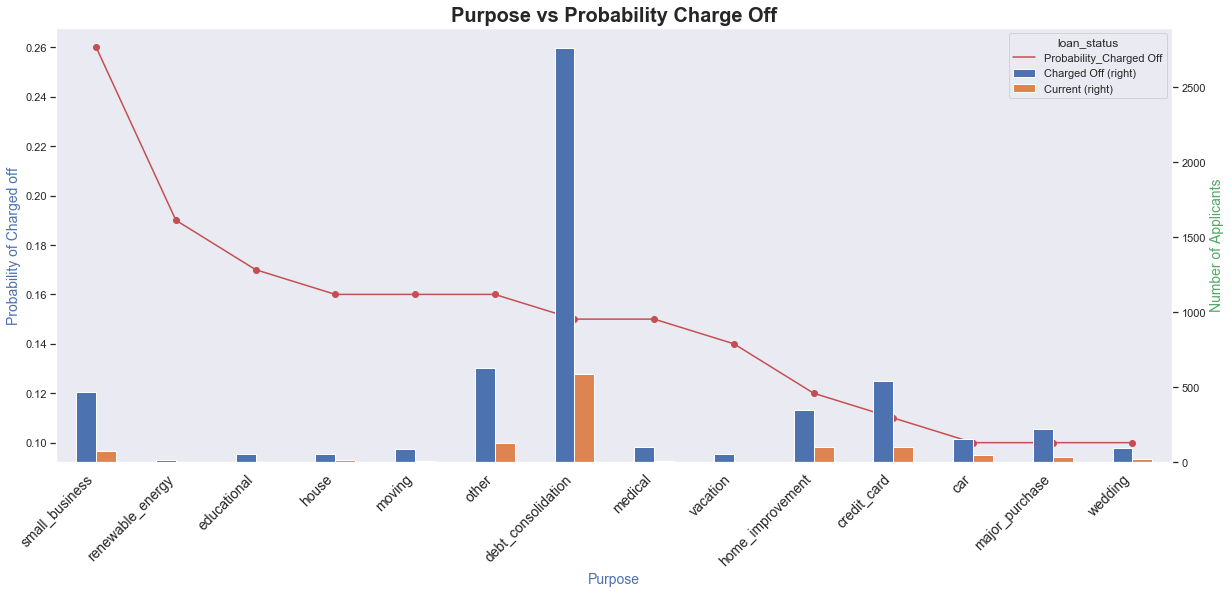

In [321]:
purpose = createCrosstab(loan_data_Df,'purpose')
display(purpose)

bivariateProb(df =loan_data_Df,col ='purpose',stacked=False)

<font color ='green'>

### Inference #27
### 1. The loans taken for the purpose of 'small_business' are most likely to be charged Off

</font>

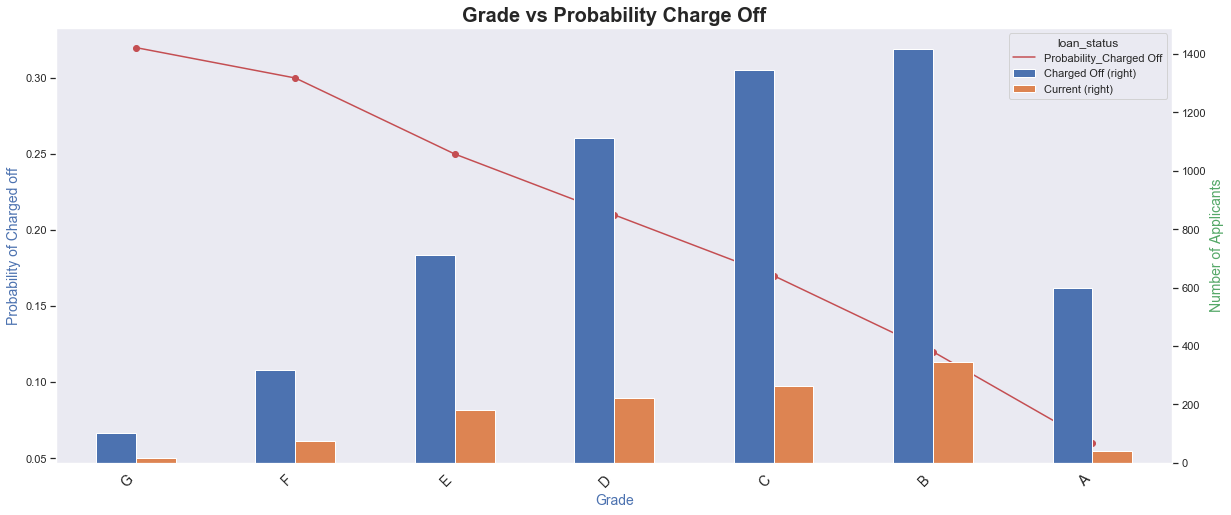

In [322]:
grade = createCrosstab(loan_data_Df,'grade')

bivariateProb(df =loan_data_Df,col ='grade',stacked=False)

<font color ='green'>

### Inference #28
### 1. The grade category of G is most likely to be charged Off

</font>

IN    9
ID    6
NE    5
IA    5
ME    3
Name: addr_state, dtype: int64


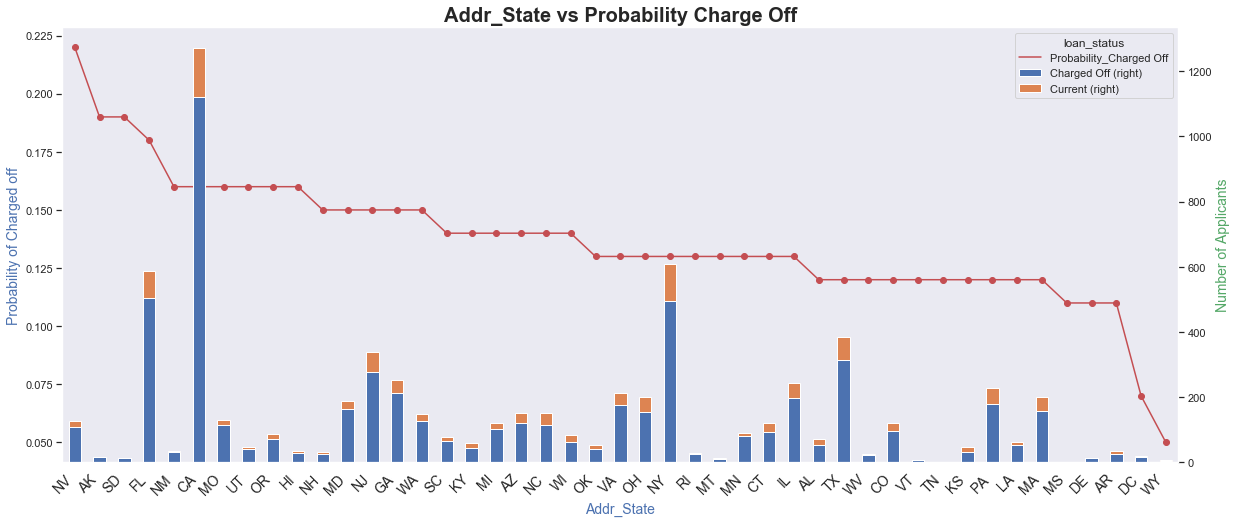

In [323]:
filter_states = loan_data_Df.addr_state.value_counts()

filter_states = filter_states[(filter_states < 10)]
print(filter_states)

loan_filter_states = loan_data_Df.drop(labels = loan_data_Df[loan_data_Df.addr_state.isin(filter_states.index)].index)

states = createCrosstab(loan_filter_states,'addr_state')

bivariateProb(df =loan_filter_states,col ='addr_state')

<font color ='green'>

### Inference #29
### 1. The loans taken in state NV are most likely to be charged Off

</font>

<font color='orange'>

### NOTE : the Outlier data treatment is done here - the data beyond the 99% are removed

</font>

300000.0
count     39616.000000
mean      68962.244975
std       63790.126168
min        4000.000000
25%       40449.000000
50%       59000.000000
75%       82297.000000
max     6000000.000000
Name: annual_inc, dtype: float64


loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
annual_inc_range,,,,,
50000-75000,1679,359,9959,6240,0.270000
0-25000,487,26,2056,2569,0.190000
25000-50000,2119,329,10687,13135,0.160000
100000 and above,590,206,4865,5661,0.100000
75000-100000,733,220,5287,11997,0.060000


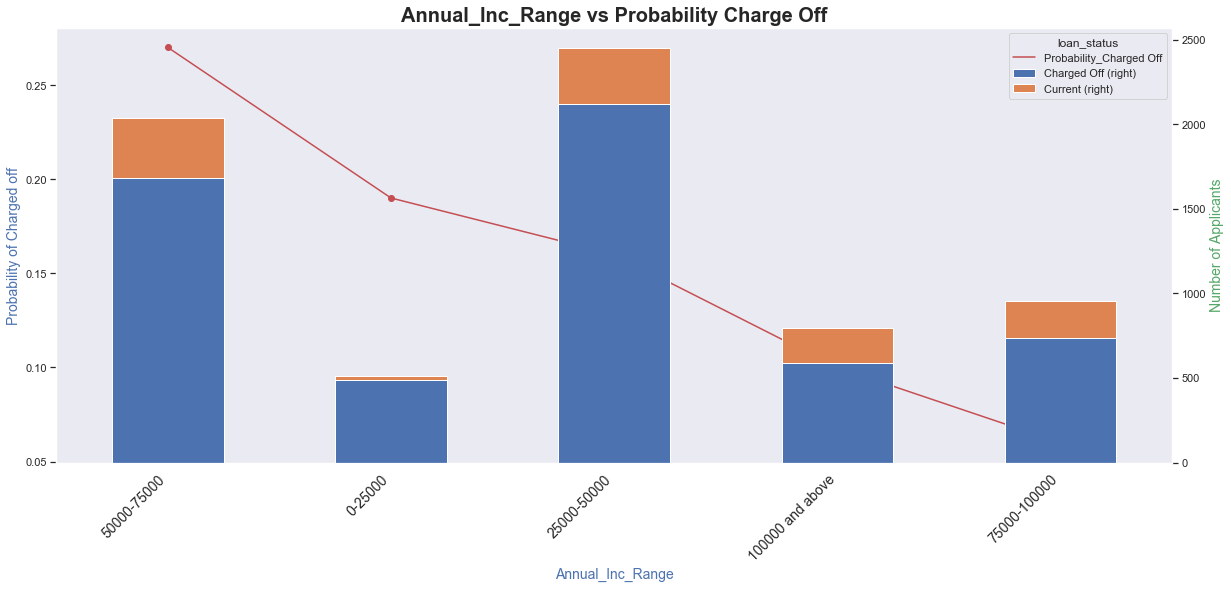

In [324]:
# Understand the annual_inc distribution 
q = loan_data_Df["annual_inc"].quantile(0.995)
print(q)

loan_df = loan_data_Df[loan_data_Df["annual_inc"] < q]

print(loan_data_Df["annual_inc"].describe())


pd.set_option('display.float_format', lambda x : '%0f' %x)

annual_inc_range = createCrosstab(loan_data_Df,'annual_inc_range')
display(annual_inc_range)

bivariateProb(df=loan_data_Df,col ='annual_inc_range')


<font color ='green'>

### Inference #30
### 1. In terms of Annual Income range , the range 50000 - 75000 are most likely to be charged Off

</font>

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
int_rate_range,,,,,
15 and above,1787,432,5421,6987,0.260000
10-12.5,1225,270,8123,5376,0.230000
12.5-15,1473,259,7391,9618,0.150000
7.5-10,572,70,6345,9123,0.060000
0-7.5,256,7,5113,7640,0.030000


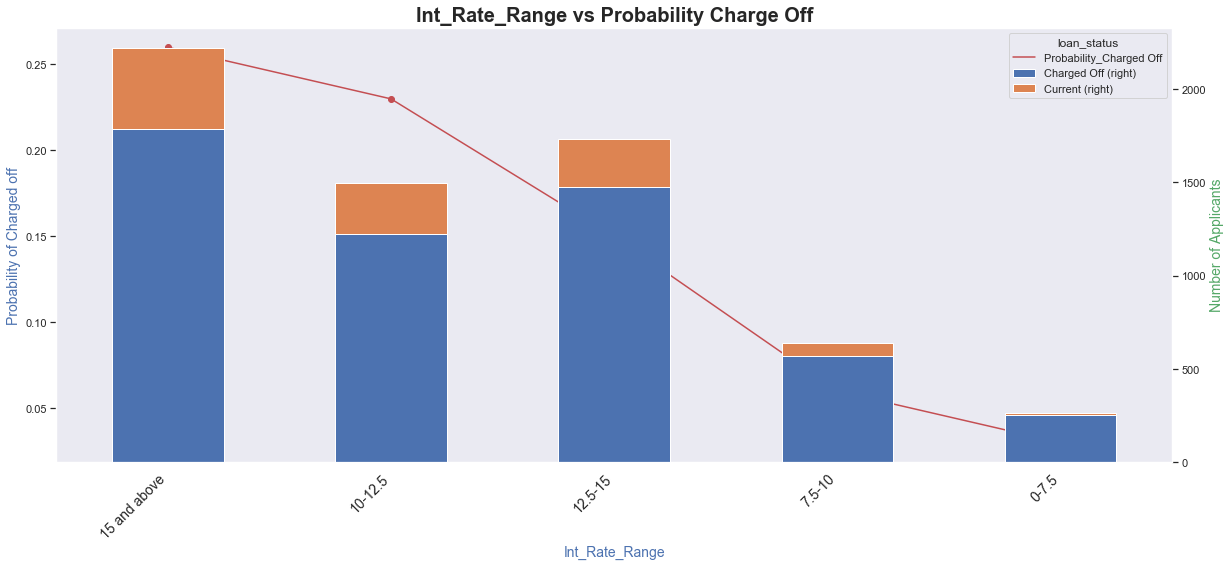

In [325]:
bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above'] 

loan_data_Df.loc[:,'int_rate_range'] = pd.cut(loan_data_Df['int_rate'], bins, labels=slot)

int_rate_range = createCrosstab(loan_data_Df,'int_rate_range')
display(int_rate_range)

bivariateProb(df =loan_data_Df,col ='int_rate_range')

<font color ='green'>

### Inference #31
### 1. The loans taken for interest rate of 15 and above  are most likely to be charged Off

</font>

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
emp_length,,,,,
0,228,42,805,1075,0.210000
10+ years,1326,391,7143,8860,0.150000
7 years,262,62,1446,1770,0.150000
1 year,452,71,2702,3225,0.140000
3 years,552,83,3450,4085,0.140000
5 years,457,88,2731,3276,0.140000
6 years,307,61,1857,2225,0.140000
8 years,203,44,1228,1475,0.140000
< 1 year,637,75,3848,4560,0.140000


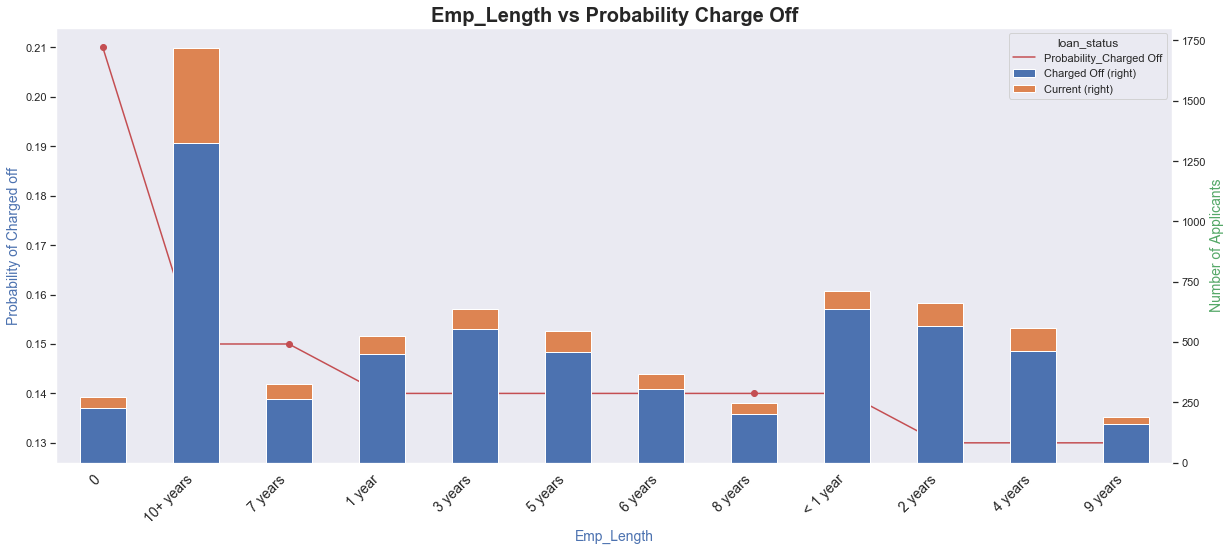

In [326]:
emp_length = createCrosstab(loan_data_Df,'emp_length')
display(emp_length)

bivariateProb(df =loan_data_Df,col ='emp_length')

<font color ='green'>

### Inference #32
### 1. The loans taken by Employees who have 0 years / are 'Indepenent' are most likely to be charged off

</font>

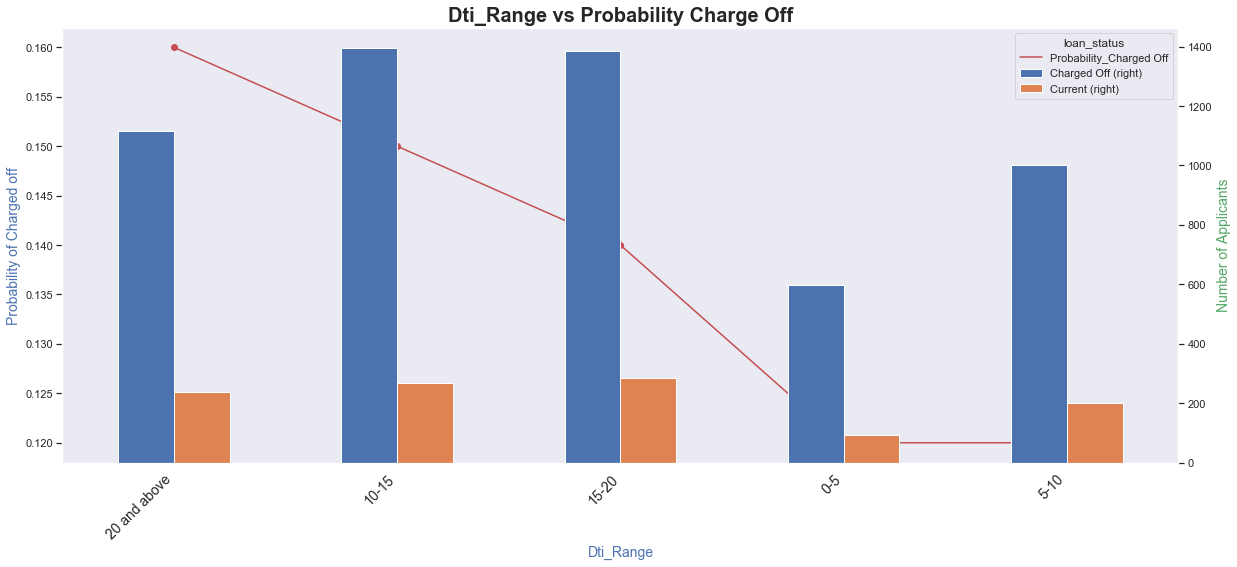

In [327]:


#Based on output, creating bins to sort the values
bins = [0,5,10,15,20,25]
slot = ['0-5','5-10','10-15','15-20','20 and above']
loan_data_Df.loc[: ,'dti_range'] = pd.cut(loan_data_Df['dti'], bins, labels = slot)

dti = createCrosstab(loan_data_Df,'dti_range')
bivariateProb(df =loan_data_Df,col ='dti_range',stacked=False)


<font color ='green'>

### Inference #33
### 1. The loan applicants with DTI range of '20 and above' is most likely to be charged off 

</font>